In [110]:
import xgboost as xgb
import uproot 
import numpy as np
import coffea
from coffea.nanoaod import NanoEvents
from coffea.nanoaod.methods.leptons import *
from coffea import hist
import matplotlib.pyplot as plt
from matplotlib import colors 
from matplotlib.ticker import PercentFormatter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [111]:
# events with 10mm displacement
fname_10mm="/uscms/home/ahall/nobackup/public/forTamas/iDM_nanoaod_ctau-10.root"
events_10mm = NanoEvents.from_file(fname_10mm,methods={"ElectronBPark":Electron})

#events with 1mm displacement
fname_1mm="/uscms/home/ahall/nobackup/public/forTamas/iDM_nanoaod.root"
events_1mm = NanoEvents.from_file(fname_1mm,methods={"ElectronBPark":Electron})

In [112]:
#event level MET-Jet cut
def MET_Jet_cut (events): 
    return events [
        (events.MET.pt >120)
        & (events.Jet.pt.max() > 80)
    ]

soft_eles_1mm = MET_Jet_cut(events_1mm).ElectronBPark
soft_eles_10mm = MET_Jet_cut(events_10mm).ElectronBPark

# recquirement for matched gen electrons
# as a cut
def matched_gen_cut (electrons):
    return electrons [
        (abs(electrons.matched_gen.pdgId) == 11) 
               & (electrons.matched_gen.parent.pdgId == 1000023)
               & (electrons.matched_gen.status == 1)
               & (electrons.matched_gen.hasFlags(["fromHardProcess", "isFirstCopy"]))
    ]
# as a mask
def matched_gen_mask (electrons):
    return ((abs(electrons.matched_gen.pdgId) == 11) 
               & (electrons.matched_gen.parent.pdgId == 1000023)
               & (electrons.matched_gen.status == 1) 
               & (electrons.matched_gen.hasFlags(["fromHardProcess", "isFirstCopy"])))

def gen_part_cut (genpart):
    return genpart [
        (abs(genpart.pdgId) == 11) 
               & (genpart.parent.pdgId == 1000023)
               & (genpart.status == 1) 
               & (genpart.hasFlags(["fromHardProcess", "isFirstCopy"]))
    ]

all_gen_eles_1mm = gen_part_cut(MET_Jet_cut(events_1mm).GenPart)
all_gen_eles_10mm = gen_part_cut(MET_Jet_cut(events_10mm).GenPart)

# define matched electrons
matched_eles_1mm = matched_gen_cut(soft_eles_1mm[soft_eles_1mm.isPF==False])
matched_eles_10mm = matched_gen_cut(soft_eles_10mm[soft_eles_10mm.isPF==False])

# defining unmatched electrons
unmatched_eles_1mm = soft_eles_1mm[(~(matched_gen_mask(soft_eles_1mm).fillna(False))) 
                                   & (soft_eles_1mm.isPF == False)]
unmatched_eles_10mm = soft_eles_10mm[(~(matched_gen_mask(soft_eles_10mm).fillna(False))) 
                                   & (soft_eles_10mm.isPF == False)]

def cut_pt(electrons):
    return electrons[
        (electrons.pt<5) 
        & (electrons.pt>1)
    ]

In [113]:
matched_var_1mm = 1 * matched_gen_mask(cut_pt(soft_eles_1mm[soft_eles_1mm.isPF==False]).flatten()).fillna(False)
matched_var_10mm = 1 * matched_gen_mask(cut_pt(soft_eles_10mm[soft_eles_10mm.isPF==False]).flatten()).fillna(False)
matched_var = np.concatenate((matched_var_1mm, matched_var_10mm))

#load variables that I found useful
id_vars = {
    '|dxy|' : np.concatenate((abs(cut_pt(soft_eles_1mm[soft_eles_1mm.isPF==False]).flatten().dxy), 
                             abs(cut_pt(soft_eles_10mm[soft_eles_10mm.isPF==False]).flatten().dxy))),
    '|dz|' : np.concatenate((abs(cut_pt(soft_eles_1mm[soft_eles_1mm.isPF==False]).flatten().dz), 
                            abs(cut_pt(soft_eles_10mm[soft_eles_10mm.isPF==False]).flatten().dz))),
    'ip3d' : np.concatenate((cut_pt(soft_eles_1mm[soft_eles_1mm.isPF==False]).flatten().ip3d, 
                            cut_pt(soft_eles_10mm[soft_eles_10mm.isPF==False]).flatten().ip3d)),
    'sip3d' : np.concatenate((cut_pt(soft_eles_1mm[soft_eles_1mm.isPF==False]).flatten().sip3d, 
                             cut_pt(soft_eles_10mm[soft_eles_10mm.isPF==False]).flatten().sip3d)),
    'fBrem' : np.concatenate((cut_pt(soft_eles_1mm[soft_eles_1mm.isPF==False]).flatten().fBrem, 
                             cut_pt(soft_eles_10mm[soft_eles_10mm.isPF==False]).flatten().fBrem)),
    'ptBiased' : np.concatenate((cut_pt(soft_eles_1mm[soft_eles_1mm.isPF==False]).flatten().ptBiased, 
                                cut_pt(soft_eles_10mm[soft_eles_10mm.isPF==False]).flatten().ptBiased)),
    'mvaId' : np.concatenate((cut_pt(soft_eles_1mm[soft_eles_1mm.isPF==False]).flatten().mvaId, 
                             cut_pt(soft_eles_10mm[soft_eles_10mm.isPF==False]).flatten().mvaId)),
    'matched?' : matched_var
}

#dataframe
df = pd.DataFrame(id_vars)
df.head()

,|dxy|,|dz|,ip3d,sip3d,fBrem,ptBiased,mvaId,matched?
0,0.000820,1.313477,1.282227,418.500000,0.942505,0.588714,0.316523,0
1,0.028015,0.081726,0.038300,6.714844,0.169434,5.654523,5.772552,0
2,0.002237,5.007812,3.263672,581.000000,-0.021198,-0.503604,-2.333933,0
3,0.002035,0.572266,0.154175,32.156250,-0.017147,4.224657,-2.241945,0
4,0.006767,0.006096,0.007271,1.182617,0.666016,0.874815,1.248869,0


In [114]:
X = df.drop('matched?', axis=1).copy()
y= df['matched?'].copy()

# print(sum(y)/len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, stratify = y, test_size=0.2)

# check if balanced
# print(sum(y_train)/len(y_train))
# print(sum(y_test)/len(y_test))

In [115]:
model_try = xgb.XGBClassifier(seed = 0) # unsure about objective

model_try.fit(X_train,
              y_train, 
             verbose=True, 
             early_stopping_rounds = 10, 
             eval_metric='aucpr',
              eval_set=[(X_test, y_test)])


[0]	validation_0-aucpr:0.20384
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.23652
[2]	validation_0-aucpr:0.26193
[3]	validation_0-aucpr:0.26761
[4]	validation_0-aucpr:0.28158
[5]	validation_0-aucpr:0.29631
[6]	validation_0-aucpr:0.28976
[7]	validation_0-aucpr:0.29200
[8]	validation_0-aucpr:0.29223
[9]	validation_0-aucpr:0.28957
[10]	validation_0-aucpr:0.28497
[11]	validation_0-aucpr:0.28997
[12]	validation_0-aucpr:0.28803
[13]	validation_0-aucpr:0.29180
[14]	validation_0-aucpr:0.29464
[15]	validation_0-aucpr:0.29485
Stopping. Best iteration:
[5]	validation_0-aucpr:0.29631



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Training accuracy:
0.9954897237455794
Testing accuracy:
0.9943007093361761


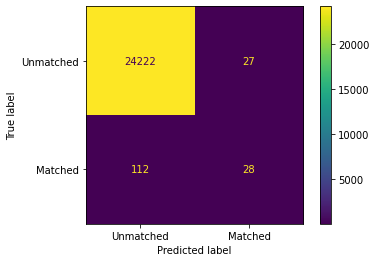

In [116]:
plot_confusion_matrix(model_try,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels = ["Unmatched", "Matched"])

y_test_predict = model_try.predict(X_test)
y_train_predict = model_try.predict(X_train)
print("Training accuracy:")
print(accuracy_score(y_train, y_train_predict))
print("Testing accuracy:")
print(accuracy_score(y_test, y_test_predict))

In [117]:
#manually adjusted parameters

In [118]:
manual_model = xgb.XGBClassifier(seed=0, 
                             objective='binary:logistic', 
                             gamma=0,
                             learning_rate = 0.05,
                             max_depth = 7,
                             reg_lambda = 5, 
                             scale_pos_weight =150, 
                             n_estimators=100, 
                             subsample=0.8, 
                            min_child_weight=1)

manual_model.fit(X_train,
              y_train, 
             verbose=False, 
             early_stopping_rounds = 10, 
             eval_metric='aucpr',
              eval_set=[(X_test, y_test)])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=5, scale_pos_weight=150, seed=0,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

Training accuracy:
0.9701296704423146
Testing accuracy:
0.9686334003034155


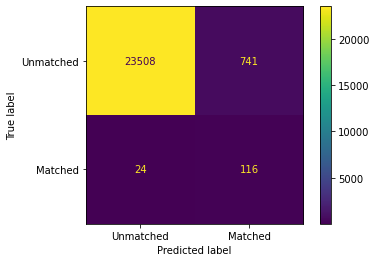

In [119]:
plot_confusion_matrix(manual_model,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels = ["Unmatched", "Matched"])

y_test_predict = manual_model.predict(X_test)
y_train_predict = manual_model.predict(X_train)
print("Training accuracy:")
print(accuracy_score(y_train, y_train_predict))
print("Testing accuracy:")
print(accuracy_score(y_test, y_test_predict))

weight:  {'ptBiased': 448, '|dz|': 462, '|dxy|': 556, 'mvaId': 536, 'fBrem': 411, 'ip3d': 333, 'sip3d': 398}
gain:  {'ptBiased': 2084.202444599105, '|dz|': 511.69240174848755, '|dxy|': 360.99828338774813, 'mvaId': 321.720258970084, 'fBrem': 149.44433110156697, 'ip3d': 441.5628062036336, 'sip3d': 221.93275616407044}
cover:  {'ptBiased': 3846.373910821431, '|dz|': 3119.5287280385282, '|dxy|': 1742.0449510048581, 'mvaId': 2592.914032472012, 'fBrem': 1171.1360812236014, 'ip3d': 2467.203778185284, 'sip3d': 1734.082083392714}
total_gain:  {'ptBiased': 933722.6951803991, '|dz|': 236401.88960780125, '|dxy|': 200715.04556358795, 'mvaId': 172442.05880796502, 'fBrem': 61421.620082744026, 'ip3d': 147040.41446581, 'sip3d': 88329.23695330003}
total_cover:  {'ptBiased': 1723175.512048001, '|dz|': 1441222.2723538, '|dxy|': 968576.9927587011, 'mvaId': 1389801.9214049985, 'fBrem': 481336.9293829002, 'ip3d': 821578.8581356996, 'sip3d': 690164.6691903002}


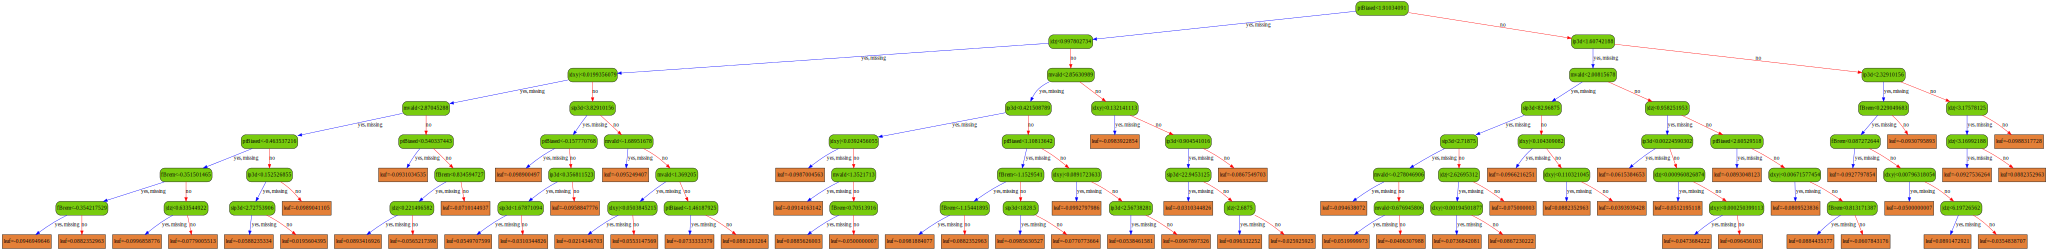

In [120]:
bst = manual_model.get_booster()

for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type = importance_type))
    
node_params = {'shape': 'box', 
              'style': 'filled, rounded', 
              'fillcolor': '#78cbe'}

leaf_params = {'shape': 'box', 
              'style': 'filled', 
              'fillcolor': '#e48038'}

xgb.to_graphviz(manual_model,
                num_trees=0, size="10,10", 
               condition_node_params=node_params, 
               leaf_node_params=leaf_params)

In [121]:
# use GridSearchCV to adjust parameters

In [122]:
#because being matched is the most important part of our analysis I'm gonna deal with the imbalance
# I'm gonna add the penalty to incorrectly classifying matched electrons
# For this I'm gonna have ot configure hyperparameters

#1st try
# parameters = {
#     'max_depth':[3, 4, 5],
#     'learning_rate':[0.1, 0.01, 0.05],
#     'gamma':[0, 0.25, 1],
#     'reg_lambda':[0, 1.0, 10.0],
#     'scale_pos_weight':[1, 3, 5]
# }

# {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 10.0, 'scale_pos_weight': 1}

#2nd try
# parameters = {
#     'max_depth':[7],
#     'learning_rate':[0.1, 0.5, 1],
#     'gamma':[1, 1.25, 2],
#     'reg_lambda':[10, 20, 100],
#     'scale_pos_weight':[0.4, 0.6, 1]
# }

# {'gamma': 2, 'learning_rate': 0.5, 'max_depth': 7, 'reg_lambda': 10, 'scale_pos_weight': 1}

#3rd try
# parameters = {
#     'max_depth':[7],
#     'learning_rate':[0.5],
#     'gamma':[2],
#     'reg_lambda':[10],
#     'scale_pos_weight':[1]
# }

#OPTIMAL PARAMETERS:
# {'gamma': 2, 'learning_rate': 0.5, 'max_depth': 7, 'reg_lambda': 10, 'scale_pos_weight': 1}

# optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', seed=11), 
#                              param_grid = parameters, 
#                              scoring='roc_auc',
#                              verbose=0,
#                              cv=3)
# optimal_params.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='auc', eval_set=[(X_test, y_test)], verbose=False)
# print(optimal_params.best_params_)

In [123]:
# GridSerachCV model (optimal)
# optimal_model = 